In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma, scoreatpercentile
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score

In [301]:
# Load the claims data file into a DataFrame 
file_path = "claim_data_group4_2024.csv"
claims_data_df = pd.read_csv(file_path)
claims_data_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


In [302]:
# Claim frequency will be used instead for number of claims as the period of exposure, meaning, the time a claim can occur, is also considered.
# Claim severity is the average claim amount per claim and will be used instead of the claim amount. 
claims_data_df['Frequency'] = claims_data_df['ClaimNb'] / claims_data_df['Exposure'] #Number of claims per year
claims_data_df['Severity'] = claims_data_df['ClaimAmount'] / claims_data_df['ClaimNb'] #Amount per claim

# Drop the original columns and place the new columns at the same position as the original columns 
claims_data = claims_data_df.drop(columns=['ClaimNb'])

# Fill missing values in the 'Severity' column with 0 (meaning no claim occurred)
claims_data['Severity'] = claims_data['Severity'].fillna(0)

# Descriptive Statistics

In [303]:
def plot_variable(data, group_var, ax_freq, ax_sev):
    """
    Function to plot frequency and severity of claims by policyholder characteristics.
    
    :param data: DataFrame to plot.
    :param group_var: The variable to group by.
    :param ax_freq: The axes object for frequency plots.
    :param ax_sev: The axes object for severity plots.
    """
    # Calculate frequency and severity
    freq = data.groupby(group_var)['Frequency'].sum()
    sev = data[data['Frequency'] > 0].groupby(group_var)['ClaimAmount'].mean()
    
    dollar_formatter = FuncFormatter(lambda x, pos: f'${int(x)}')

    # Plot Frequency
    sns.barplot(x=freq.index, y=freq.values, ax=ax_freq)
    ax_freq.set_title(f'Claim Frequency by {group_var}')
    ax_freq.set_xlabel(group_var)
    ax_freq.set_ylabel('Total Claims')
    ax_freq.tick_params(axis='x')
    if group_var in ['BonusMalus','DrivAge', 'VehAge']:
        ax_freq.xaxis.set_major_locator(MaxNLocator(10))

    # Plot Severity
    sns.barplot(x=sev.index, y=sev.values, ax=ax_sev)
    ax_sev.set_title(f'Claim Severity by {group_var}')
    ax_sev.set_xlabel(group_var)
    ax_sev.set_ylabel('Average Claim Amount')
    ax_sev.tick_params(axis='x')
    ax_sev.yaxis.set_major_formatter(dollar_formatter)
    if group_var in ['BonusMalus', 'DrivAge']:
        ax_sev.xaxis.set_major_locator(MaxNLocator(10))

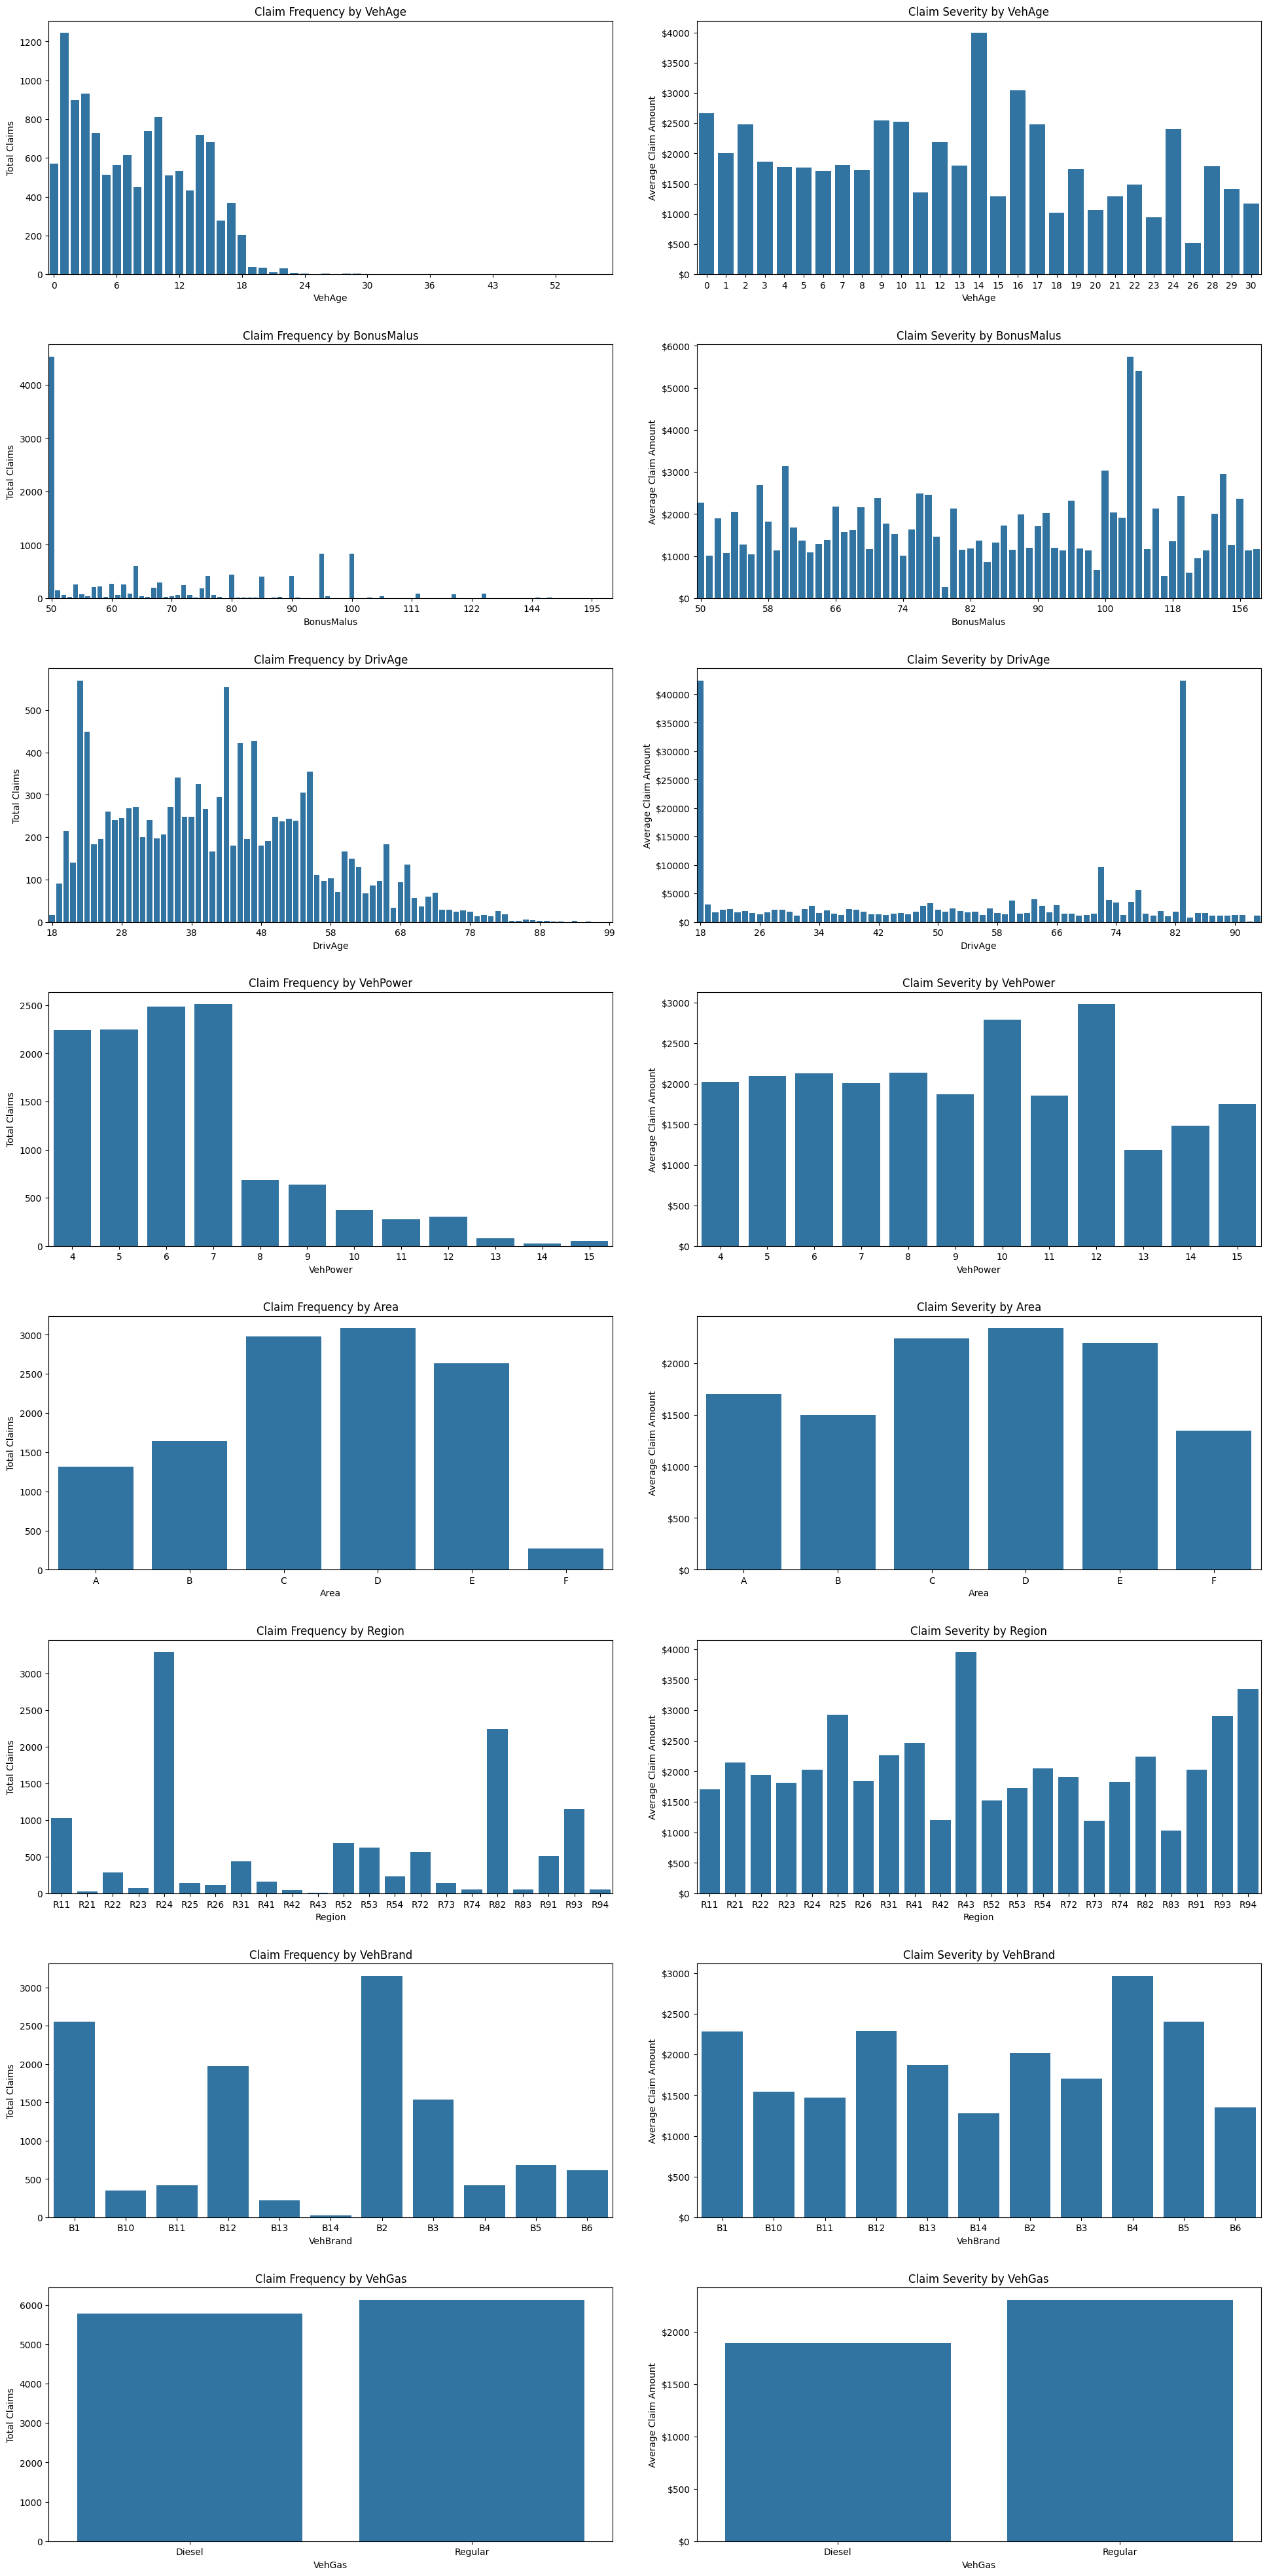

In [304]:
# Variables to plot frequency and severity of claims by policyholder characteristics
variables = ['VehAge', 'BonusMalus', 'DrivAge', 'VehPower', 'Area','Region', 'VehBrand', 'VehGas']

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(20, 5 * len(variables))) 

# Loop through each variable and apply the plotting function on subplots
for idx, var in enumerate(variables):
    plot_variable(claims_data, var, axes[idx, 0], axes[idx, 1])

plt.tight_layout(pad=3.0) 
plt.show()

In [205]:
# Check for correlation between risk caracteristics (VehPower, DrivAge, BonusMalus, VehAge, Density)
claims_data[['VehPower', 'DrivAge', 'BonusMalus', 'VehAge', 'Density']].corr()

,VehPower,DrivAge,BonusMalus,VehAge,Density
VehPower,1.000000,0.028375,-0.077144,-0.006254,0.044586
DrivAge,0.028375,1.000000,-0.480037,-0.057351,-0.005337
BonusMalus,-0.077144,-0.480037,1.000000,0.084034,0.080366
VehAge,-0.006254,-0.057351,0.084034,1.000000,-0.091280
Density,0.044586,-0.005337,0.080366,-0.091280,1.000000


- Most of the correlations between the variables are weak (close to 0), indicating that there is no strong linear relationship between most pairs of variables.
- The only moderate correlation is between DrivAge and BonusMalus (-0.480037), suggesting that as the driver's age increases, the Bonus-Malus score tends to decrease.
- Redundancy: If two variables are highly correlated, they provide similar information to the model. Including both might not add significant value and can lead to redundancy.

In [206]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Frequency,Severity
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,2.617735e+06,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887,0.119194,70.764054
std,1.643394e+06,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302,2.141210,1448.674413
min,1.500000e+01,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000,0.000000,0.000000
25%,1.156127e+06,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000,0.000000,0.000000
50%,2.271008e+06,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000,0.000000,0.000000
75%,4.044791e+06,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000,0.000000,0.000000
max,6.114324e+06,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000,365.000004,200000.000000


In [207]:
total_claims_frequency = pd.DataFrame(claims_data['Frequency'].value_counts())
total_claims_frequency

,count
Frequency,
0.000000,96335
1.000000,1247
2.000000,146
2.040816,59
4.166667,53
...,...
22.222222,1
2.597403,1
121.666668,1


In [208]:
total_claims_severity = pd.DataFrame(claims_data['Severity'].value_counts())
total_claims_severity

,count
Severity,
0.00,96335
1204.00,662
1128.12,409
1172.00,290
1128.00,96
...,...
1307.64,1
1858.81,1
741.77,1


In [209]:
# Total claims by driver's age 
total_claims_by_age_frequency = claims_data.groupby('DrivAge')['Frequency'].sum()
total_claims_by_age_severity = claims_data.groupby('DrivAge')['Severity'].sum()
total_claims_by_age_frequency = pd.DataFrame(total_claims_by_age_frequency)
total_claims_by_age_severity = pd.DataFrame(total_claims_by_age_severity)
pd.concat([total_claims_by_age_frequency, total_claims_by_age_severity], axis=1)

,Frequency,Severity
DrivAge,,
18,16.322587,210524.965
19,91.403724,78742.210
20,213.609450,90009.665
21,140.569510,85914.745
22,569.546878,98199.640
...,...,...
94,0.000000,0.000
95,1.234568,1172.000
96,0.000000,0.000


In [210]:
# Total claims by vehicle's age 
total_claims_by_vech_age_frequency = claims_data.groupby('VehAge')['Frequency'].sum()
total_claims_by_vech_age_severity = claims_data.groupby('VehAge')['Severity'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_vech_age_frequency)
total_claims_by_vech_age_severity = pd.DataFrame(total_claims_by_vech_age_severity)
pd.concat([total_claims_by_vech_age_frequency, total_claims_by_vech_age_severity], axis=1)

,Frequency,Severity
VehAge,,
0,570.358022,362637.860000
1,1244.758156,512712.610000
2,896.493005,692091.993333
3,930.549972,473189.545000
4,729.686639,405445.130000
5,511.978097,367661.745000
6,562.314874,329915.165000
7,615.062916,359821.105000
8,450.012112,364441.425000


In [211]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus_frequency = claims_data.groupby('BonusMalus')['Frequency'].sum()
total_claims_by_bonus_malus_severity = claims_data.groupby('BonusMalus')['Severity'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_bonus_malus_frequency)
total_claims_by_bonus_malus_severity = pd.DataFrame(total_claims_by_bonus_malus_severity)
pd.concat([total_claims_by_bonus_malus_frequency, total_claims_by_bonus_malus_severity], axis=1)

,Frequency,Severity
BonusMalus,,
50,4527.854394,3.367297e+06
51,144.747215,5.606332e+04
52,66.867186,4.866783e+04
53,27.815301,1.939749e+04
54,260.253699,1.228630e+05
...,...,...
190,0.000000,0.000000e+00
195,0.000000,0.000000e+00
196,0.000000,0.000000e+00


In [212]:
# Total claims by vechicle's power 
total_claims_by_vech_power_frequency = claims_data.groupby('VehPower')['Frequency'].sum()
total_claims_by_vech_power_severity = claims_data.groupby('VehPower')['Severity'].sum()
total_claims_by_vech_power_frequency = pd.DataFrame(total_claims_by_vech_power_frequency)
total_claims_by_vech_power_severity = pd.DataFrame(total_claims_by_vech_power_severity)
pd.concat([total_claims_by_vech_power_frequency, total_claims_by_vech_power_severity], axis=1)

,Frequency,Severity
VehPower,,
4,2241.808393,8.955589e+05
5,2248.298384,1.481127e+06
6,2487.080157,1.690078e+06
7,2509.899334,1.445924e+06
8,686.681816,4.745916e+05
9,637.763083,3.144667e+05
10,374.189024,3.860403e+05
11,274.163323,1.689012e+05
12,305.273969,1.525144e+05


# Cluster

*Catégorisation des variables*

In [305]:
# Function to perform quantile binning and apply it to the claims data set
def quantile_binning_and_apply(claims_data, features, n_bins, specific_bins=None):
    bin_labels_dict = {}
    for feature in features:
        # Used a specific number of bins for some features or n_bins if not specified
        bins = specific_bins.get(feature, n_bins) if specific_bins else n_bins
        bin_edges = pd.qcut(claims_data[feature], q=bins, retbins=True, duplicates='drop')[1]
        bin_edges[-1] += 1e-5
        labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
        claims_data[f'Binned {feature}'] = pd.cut(claims_data[feature], bins=bin_edges, labels=labels, include_lowest=True, duplicates='drop')
        bin_labels_dict[f'Binned {feature}'] = labels
        print(f'Labels for {feature}: {labels}')
    return bin_labels_dict

# Treatment of BonusMalus as specified in the project description 
claims_data['Binned BonusMalus'] = claims_data['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

In [306]:
# List of features to bin and number of bins for each feature
features = ['DrivAge', 'VehAge','VehPower']
n_bins = 10

# Define the numbers of bins for specific features (DrivAge), to get more granularity into the bins classification
specific_bins = {'DrivAge': 20}  # Par exemple, 30 bins pour DrivAge pour plus de granularité

# Call the function
bin_labels_dict = quantile_binning_and_apply(claims_data, features, n_bins, specific_bins)

Labels for DrivAge: ['18.0-25.0', '25.0-28.0', '28.0-30.0', '30.0-32.0', '32.0-34.0', '34.0-36.0', '36.0-38.0', '38.0-40.0', '40.0-42.0', '42.0-44.0', '44.0-46.0', '46.0-48.0', '48.0-51.0', '51.0-53.0', '53.0-55.0', '55.0-57.0', '57.0-61.0', '61.0-65.0', '65.0-72.0', '72.0-99.0']
Labels for VehAge: ['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-15.0', '15.0-100.0']
Labels for VehPower: ['4.0-5.0', '5.0-6.0', '6.0-7.0', '7.0-8.0', '8.0-9.0', '9.0-15.0']


*Determining the optimal amount of clusters*

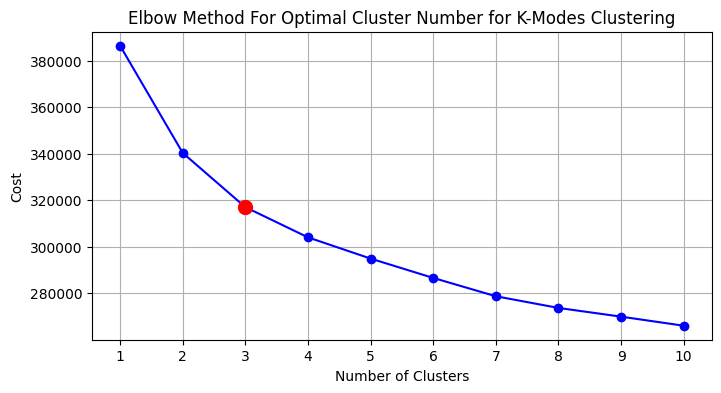

In [215]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus']

# Prepare data for one-hot encoding
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering 
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array before applying K-Modes 
data_matrix = df_categorical.to_numpy()

# Apply the elbow method to find the optimal number of clusters for K-Modes clustering method
cost = []
K = range(1, 11)  # Range of clusters to try for the elbow method 
for num_clusters in K:
    kmodes = KModes(n_clusters=num_clusters, random_state=42)
    clusters = kmodes.fit_predict(data_matrix)
    cost.append(kmodes.cost_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K, cost, marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Cluster Number for K-Modes Clustering')
plt.xticks(K)
plt.grid(True)

# Highlight the optimal number of clusters (3) in red 
optimal_k = 3
plt.plot(optimal_k, cost[optimal_k - 1], marker='o', markersize=10, color='r')
plt.show()

*Creating the clusters using K-Modes Clustering Method*

In [307]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus'] # See if we add more columns to improve the clustering results 

# Prepare data for categorical columns 
# Combine binned features and additional categorical columns
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns

# Convert categorical columns to category type
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array
data_matrix = df_categorical.to_numpy()

# Apply K-Modes clustering with the optimal number of clusters 
kmodes = KModes(n_clusters=3, random_state=42)

# Fit the model to the data 
clusters = kmodes.fit_predict(data_matrix)

# Store the result in 'Risk Cluster' column 
claims_data['Risk Cluster K-Mode'] = clusters

In [341]:
def apply_k_modes_clustering(claims_data, features, additional_categorical_columns, n_clusters, random_state):
    """
    Apply K-Modes clustering on categorical data.
    
    Parameters:
        claims_data (DataFrame): The DataFrame containing the claims data.
        features (list): List of features to be binned and included in the clustering.
        additional_categorical_columns (list): List of additional categorical columns to include.
        n_clusters (int, optional): The number of clusters to form. Defaults to 3.
        random_state (int, optional): Random state for reproducibility. Defaults to 42.
    
    Returns:
        DataFrame: The DataFrame with an additional column 'Risk Cluster K-Mode' indicating the cluster assignment.
    """
    # Combine binned features and additional categorical columns
    categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
    
    # Convert categorical columns to category type
    for col in categorical_columns:
        claims_data[col] = claims_data[col].astype('category')
    
    # Use only categorical columns for clustering
    df_categorical = claims_data[categorical_columns]
    
    # Convert the DataFrame to a numpy array
    data_matrix = df_categorical.to_numpy()
    
    # Apply K-Modes clustering
    kmodes = KModes(n_clusters=n_clusters, random_state=random_state)
    clusters = kmodes.fit_predict(data_matrix)
    
    # Store the result in 'Risk Cluster K-Mode' column
    claims_data['Risk Cluster K-Mode'] = clusters
    
    return claims_data

# Assuming your DataFrame is named claims_data
updated_claims_data = apply_k_modes_clustering(
    claims_data=claims_data,
    features=features,
    additional_categorical_columns=additional_categorical_columns,
    n_clusters=3,  # Number of clusters you want
    random_state=42  # Seed for reproducibility
)


*Validate the clusters defined by the K-Modes algorithm using CatBoostClassifier*

In [308]:
# Extract labels from the 'Risk Cluster' column of K-Modes clustering
labels = claims_data['Risk Cluster K-Mode']

# Identify categorical feature indices for CatBoost model to use 
cat_features_indices = [df_categorical.columns.get_loc(col) for col in categorical_columns]

# Split the data into training and testing sets (20% test data) and use the rest as training data (20% was the best split ratio based on GridSearchCV results optimization run)
X_train, X_test, y_train, y_test = train_test_split(df_categorical, labels, test_size=0.2, random_state=42)

# Train a CatBoost classifier with adjusted parameters
model = CatBoostClassifier(
    iterations=500,          # Number of iterations are based on GridSearchCV results optimization run to find the best parameters 
    learning_rate=0.1,      # Number of iterations are based on GridSearchCV results optimization run to find the best parameters
    depth=10,                 # Depth of the tree are based on GridSearchCV results optimization run to find the best parameters
    random_seed=42,          # Random seed for reproducibility
    cat_features=cat_features_indices # Categorical feature indices for CatBoost model to use 
    )
model.fit(X_train, y_train)

# Predict on the entire dataset to get the predicted risk clusters (Validation) 
claims_data['Predicted Risk Cluster'] = model.predict(df_categorical)

0:	learn: 0.9590885	total: 346ms	remaining: 2m 52s
1:	learn: 0.8522171	total: 745ms	remaining: 3m 5s
2:	learn: 0.7631748	total: 1.09s	remaining: 3m
3:	learn: 0.6881025	total: 1.36s	remaining: 2m 48s
4:	learn: 0.6271395	total: 1.65s	remaining: 2m 43s
5:	learn: 0.5744777	total: 1.97s	remaining: 2m 41s
6:	learn: 0.5302366	total: 2.23s	remaining: 2m 37s
7:	learn: 0.4912163	total: 2.42s	remaining: 2m 28s
8:	learn: 0.4535651	total: 2.63s	remaining: 2m 23s
9:	learn: 0.4194899	total: 2.81s	remaining: 2m 17s
10:	learn: 0.3890516	total: 3.01s	remaining: 2m 13s
11:	learn: 0.3618022	total: 3.19s	remaining: 2m 9s
12:	learn: 0.3339199	total: 3.38s	remaining: 2m 6s
13:	learn: 0.3095599	total: 3.57s	remaining: 2m 3s
14:	learn: 0.2900302	total: 3.74s	remaining: 2m 1s
15:	learn: 0.2721421	total: 3.93s	remaining: 1m 58s
16:	learn: 0.2551998	total: 4.12s	remaining: 1m 57s
17:	learn: 0.2394547	total: 4.31s	remaining: 1m 55s
18:	learn: 0.2250239	total: 4.53s	remaining: 1m 54s
19:	learn: 0.2109746	total: 4.7

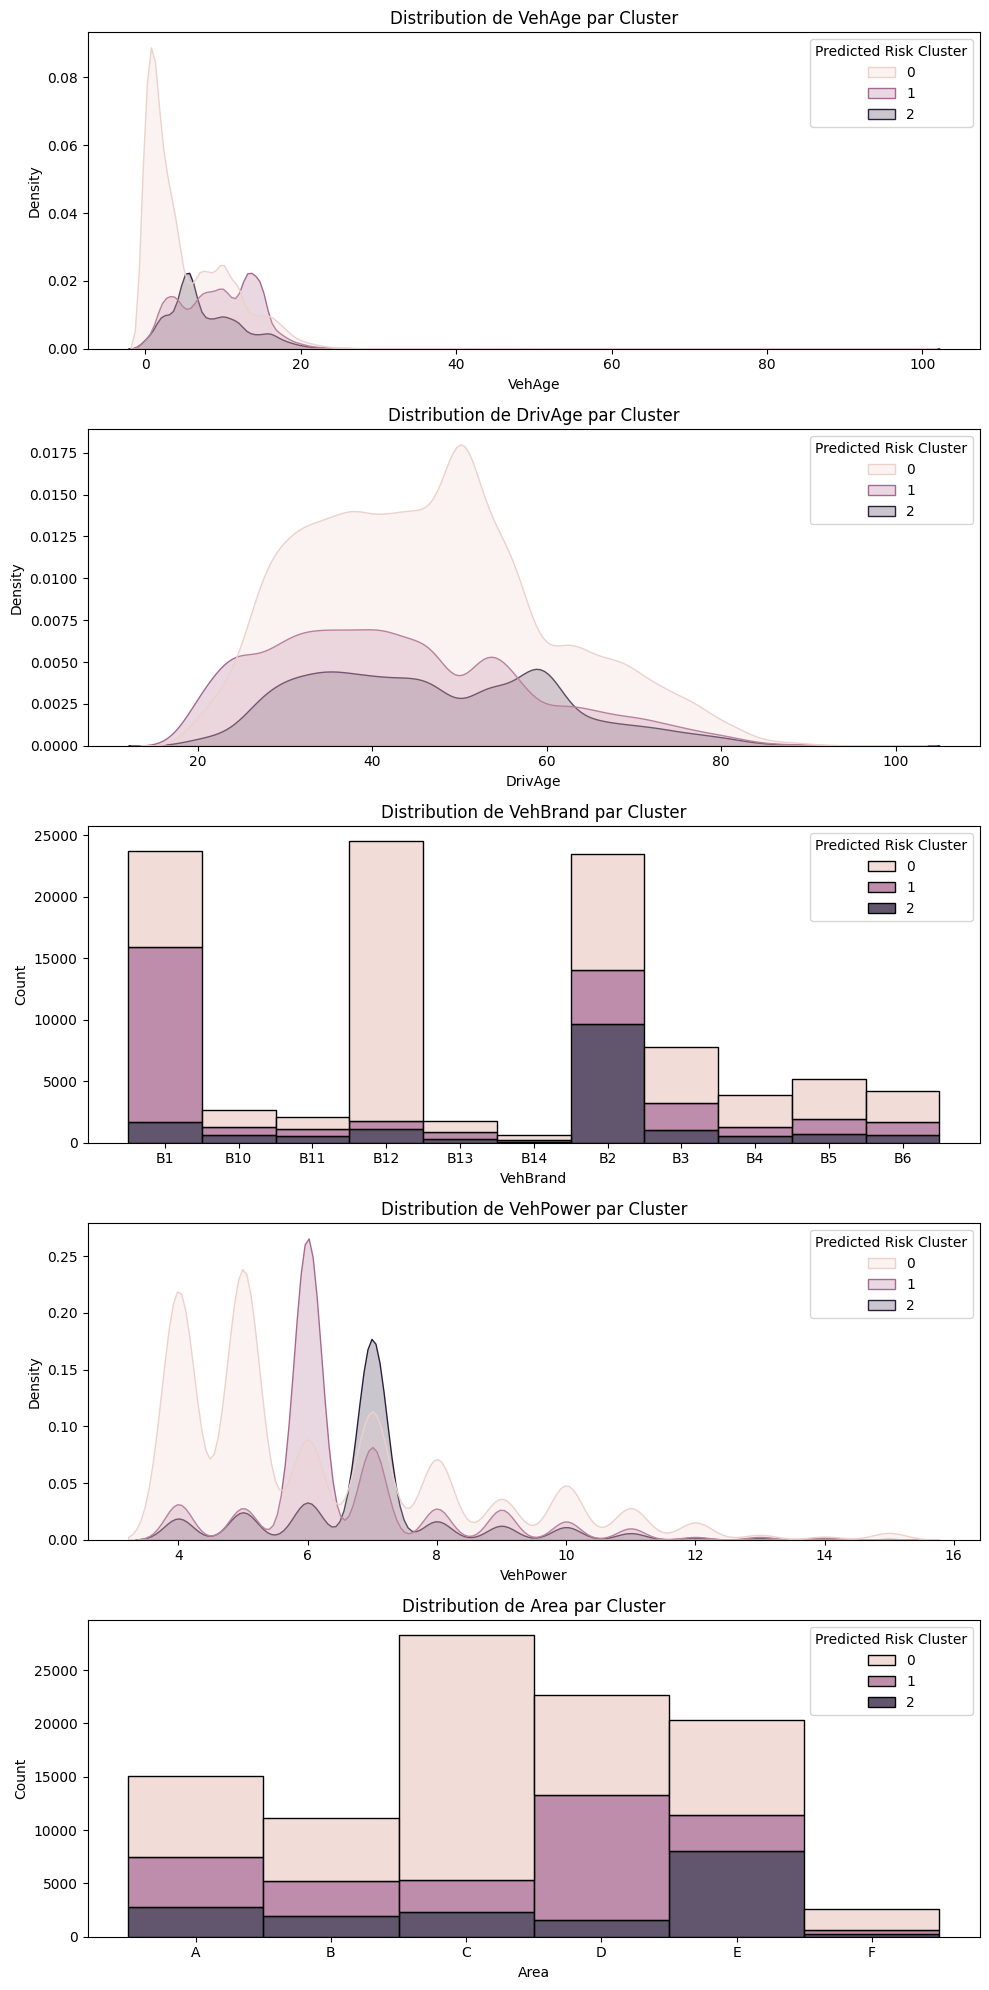

In [218]:
# Define the variables to plot 
variables = ['VehAge', 'DrivAge', 'VehBrand', 'VehPower', 'Area']
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 20))

# Plot the distribution of variables by predicted risk cluster
# We use sns.histplot for categorical variables and sns.kdeplot for numerical variables.
# This allows us to visualize how different variables are distributed across the predicted risk clusters.
for i, var in enumerate(variables):
    assert var in claims_data.columns, f"La colonne {var} est manquante dans claims_data"
    if claims_data[var].dtype.name == 'category' or claims_data[var].dtype.name == 'object':
        sns.histplot(data=claims_data, x=var, hue='Predicted Risk Cluster', multiple="stack", ax=axes[i])
    else:
        sns.kdeplot(data=claims_data, x=var, hue='Predicted Risk Cluster', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {var} par Cluster')

# Adjust the layout of the subplots to avoid overlap 
plt.tight_layout()
plt.show()

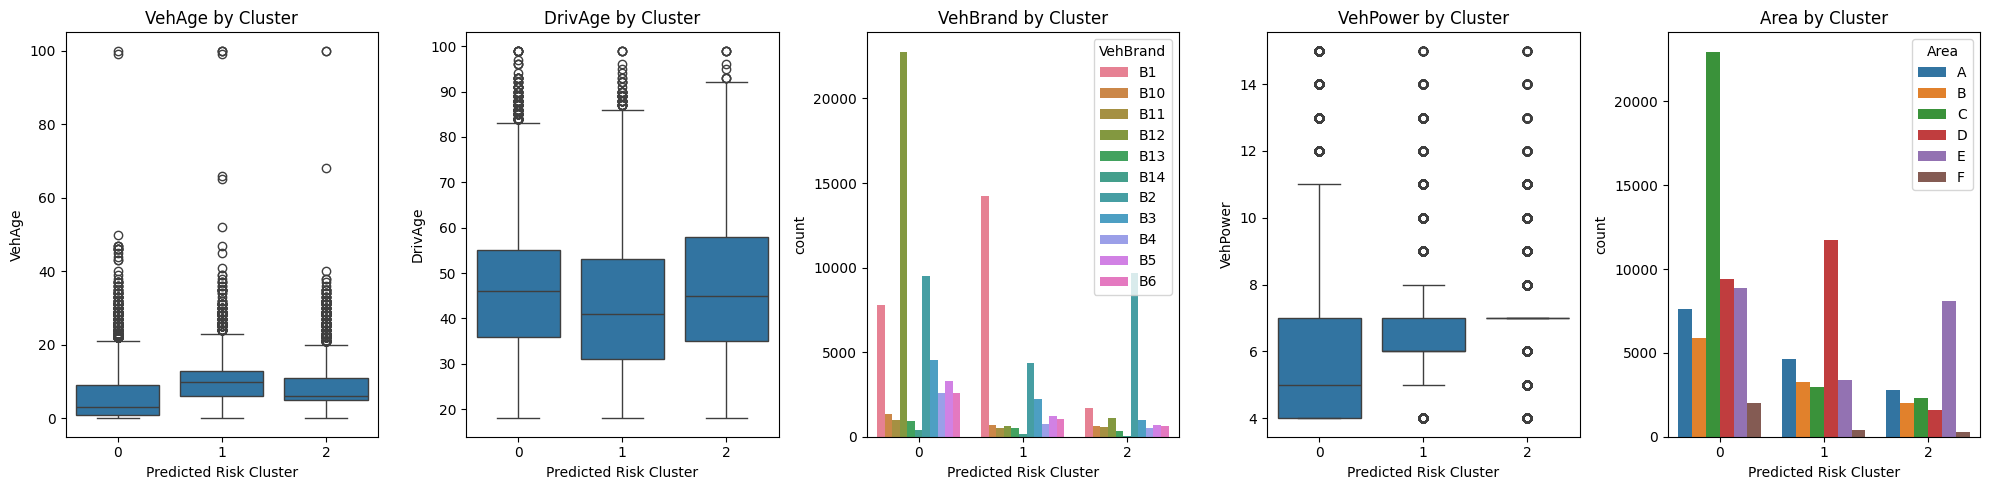

In [219]:
# Define the variables to plot
variables = ['VehAge', 'DrivAge', 'VehBrand', 'VehPower', 'Area']
fig, axes = plt.subplots(1, len(variables), figsize=(20, 5))

# Plot the distribution of variables by predicted risk cluster
# Use sns.boxplot for numerical variables and sns.countplot for categorical variables to visualize the distribution of variables by predicted risk clusters.
for i, var in enumerate(variables):
    assert var in claims_data.columns, f"The column {var} is missing in claims_data"
    if claims_data[var].dtype.name == 'category' or claims_data[var].dtype.name == 'object':
        sns.countplot(data=claims_data, x='Predicted Risk Cluster', hue=var, ax=axes[i])
    else:
        sns.boxplot(data=claims_data, x='Predicted Risk Cluster', y=var, ax=axes[i])
    axes[i].set_title(f'{var} by Cluster')

# Adjust the layout of the subplots to avoid overlap
plt.tight_layout()
plt.show()

- These visualizations help in understanding how different features influence the predicted risk clusters and in evaluating the performance of the clustering model.

*Cross Validation Test for Catboost predictive model*

In [296]:
# Perform cross-validation - takes too long to run, was simply done for validation purposes
#cv_scores = cross_val_score(model, df_categorical, labels, cv=5, scoring='accuracy')

# Print cross-validation scores
#print("Cross-validation scores:", cv_scores)
#print("Mean cross-validation score:", cv_scores.mean())

# Mean cross-validation score = 0.9999

0:	learn: 0.9668572	total: 149ms	remaining: 1m 14s
1:	learn: 0.8694815	total: 461ms	remaining: 1m 54s
2:	learn: 0.7872921	total: 700ms	remaining: 1m 55s
3:	learn: 0.7095477	total: 861ms	remaining: 1m 46s
4:	learn: 0.6436884	total: 1.06s	remaining: 1m 45s
5:	learn: 0.5900515	total: 1.32s	remaining: 1m 48s
6:	learn: 0.5447845	total: 1.52s	remaining: 1m 47s
7:	learn: 0.5039698	total: 1.69s	remaining: 1m 43s
8:	learn: 0.4679559	total: 1.86s	remaining: 1m 41s
9:	learn: 0.4360790	total: 2.03s	remaining: 1m 39s
10:	learn: 0.4032829	total: 2.21s	remaining: 1m 38s
11:	learn: 0.3731734	total: 2.37s	remaining: 1m 36s
12:	learn: 0.3497200	total: 2.55s	remaining: 1m 35s
13:	learn: 0.3238842	total: 2.73s	remaining: 1m 34s
14:	learn: 0.3017919	total: 2.89s	remaining: 1m 33s
15:	learn: 0.2823201	total: 3.07s	remaining: 1m 32s
16:	learn: 0.2642639	total: 3.23s	remaining: 1m 31s
17:	learn: 0.2464323	total: 3.39s	remaining: 1m 30s
18:	learn: 0.2315482	total: 3.56s	remaining: 1m 30s
19:	learn: 0.2170596	t

# Interpret Clusters and Validate Clusters as Risk Groups

In [297]:
# Enconding categorical data to evaluate the clusters - also a bit long 
df_categorical_encoded = OneHotEncoder().fit_transform(df_categorical)
silhouette = silhouette_score(df_categorical_encoded, claims_data['Predicted Risk Cluster'])
davies_bouldin = davies_bouldin_score(df_categorical_encoded.toarray(), claims_data['Predicted Risk Cluster'])

print(f"Silhouette Score: {silhouette}")
print(f"Davies Bouldin Score: {davies_bouldin}")

Silhouette Score: 0.04166128773615188
Davies Bouldin Score: 4.020328720316979


- Overall, these scores indicate that the k-modes clustering may not have formed perfectly well-defined and distinct clusters in this dataset. However, we selected the k-modes clustering method for its simplicity to implement and understand. This choice is a concession we made to balance ease of use and interpretability with the clustering performance.

*Extraire les caractéristiques dominantes de chaque cluster : Utiliser les centroids des clusters pour comprendre les caractéristiques principales de chaque groupe.*

In [362]:
# Count the number of data points in each cluster predicted by the CatBoost model
predicted_cluster_counts = claims_data['Risk Cluster K-Mode'].value_counts()
print("Number of data points in each predicted cluster:")
print(predicted_cluster_counts)

# Function to get the most frequent values (mode) for each feature in each cluster
def get_cluster_modes(df, cluster_col, feature_cols):
    # Group by the cluster column and calculate the mode for each feature
    cluster_modes = df.groupby(cluster_col)[feature_cols].agg(lambda x: x.mode().iloc[0])
    return cluster_modes

# Columns to analyze
feature_cols = ['Binned DrivAge', 'Binned VehAge', 'Binned VehPower', 'Area', 'VehBrand', 'Binned BonusMalus']

# Get the most frequent values for each cluster
cluster_modes = get_cluster_modes(claims_data,'Risk Cluster K-Mode', feature_cols)

# Display common characteristics for each cluster
cluster_modes

Number of data points in each predicted cluster:
Risk Cluster K-Mode
0    56680
1    26313
2    17007
Name: count, dtype: int64


,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Binned BonusMalus
Risk Cluster K-Mode,,,,,,
0,48.0-51.0,0.0-1.0,4.0-5.0,C,B12,Bonus
1,18.0-25.0,12.0-15.0,5.0-6.0,D,B1,Bonus
2,57.0-61.0,4.0-6.0,6.0-7.0,E,B2,Bonus


- We can see that our risk cluster are well diversified and defined. They do not exhibited overlap in key risk-defining characteristics, such as in Driver Age, Vehicle Age, Vehicle Brand, Vehicle Power and Area. 
- The Bonus/Malus variable does not show a significant impact on the clustering process. Also, it is highly correlated with Driver Age (please refer to the correlation matrix at the top of the code file), meaning this is not a variable we will retain in our final risk classification algorithm to groups insured based ontheir observable characteristics.

/var/folders/_j/nh059vw94tn4ypg5kqrr4hm40000gn/T/ipykernel_64395/1757589572.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=cluster_frequency, x='Risk Cluster K-Mode', y='Frequency', palette= 'viridis')


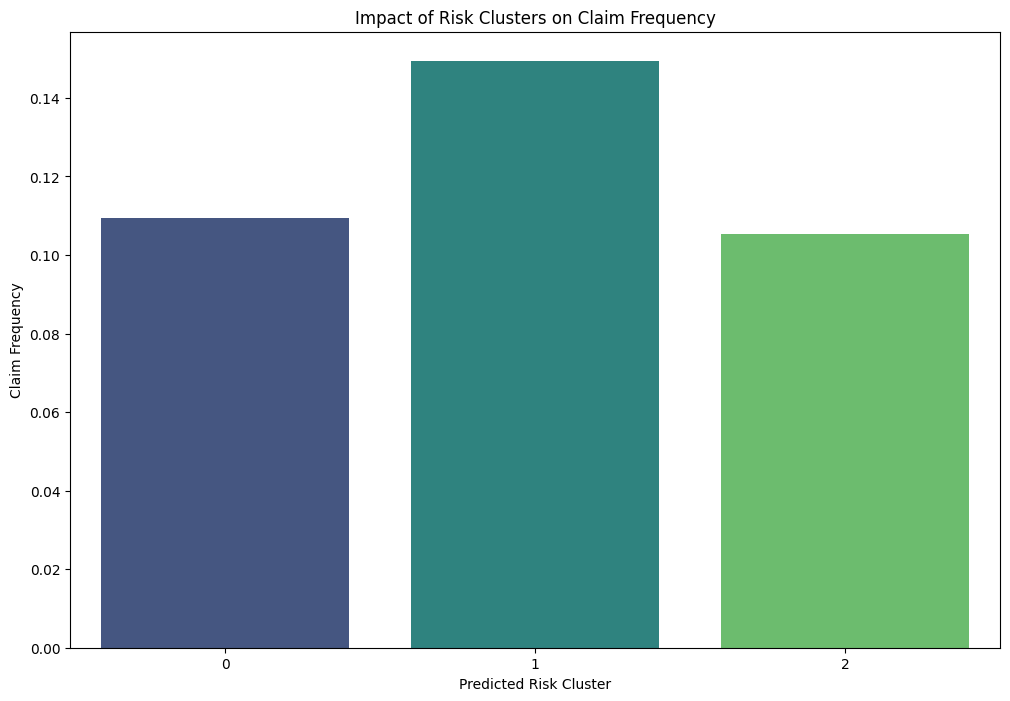

In [223]:
# Calculate the mean claim frequency for each predicted risk cluster
cluster_frequency = claims_data.groupby('Risk Cluster K-Mode')['Frequency'].mean().reset_index()

# Create a bar plot to visualize the impact of each cluster on claim frequency to see the riskiest cluster and the 'safest' cluster
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=cluster_frequency, x='Risk Cluster K-Mode', y='Frequency', palette= 'viridis')

plt.title('Impact of Risk Clusters on Claim Frequency')
plt.xlabel('Predicted Risk Cluster')
plt.ylabel('Claim Frequency')
plt.show()

- Cluster 1 tend to be the most riskiest cluster in our risk classification process, resulting in higher claims frequencies, followed by cluster 0 and 2. 

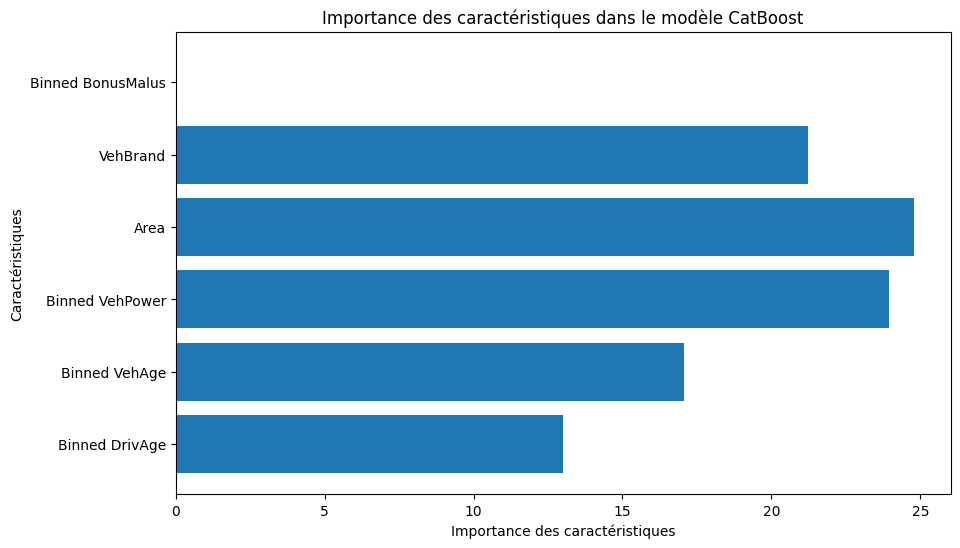

In [224]:
# CatBoost provides built-in methods to extract feature importance, which can offer insights into what features are driving the distinctions between clusters.
# Obtain which characteristics are the most important for predicting the cluster labels.
feature_importances = model.get_feature_importance()
feature_names = df_categorical.columns

# Create a bar plot to visualize the importance of each characteristics in the CatBoost model
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques dans le modèle CatBoost')
plt.show()

- The analysis using the CatBoost model to extract feature importance confirms our intuition. All variables, except for the Bonus/Malus variable, show significant importance in predicting the cluster labels. This further supports our decision to exclude the Bonus/Malus variable from the final risk classification process, as it does not contribute meaningfully.

In [344]:
# Create DataFrames based on clusters for further analysis (premium calculation, etc.)
df_cluster_0 = claims_data[claims_data['Risk Cluster K-Mode'] == 0].copy()
df_cluster_1 = claims_data[claims_data['Risk Cluster K-Mode'] == 1].copy()
df_cluster_2 = claims_data[claims_data['Risk Cluster K-Mode'] == 2].copy()

# Analysis of the total distribution

*AIC and BIC criterias*

In [311]:
# Fonctions de calcul de l'AIC et du BIC comme mesures de la qualité de fitting des différents modèles de distribution
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

*Distribution function for frequency*

In [312]:
def distrib_test(x, dist, params, title, dist_type):
    """ Test distribution and calculate AIC and BIC. """
    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

*Distribution function for severity*

In [313]:
def distrib_severity(x, dist, params, title, dist_type):
    """ Test distribution severity and calculate AIC and BIC. """
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

#### Total claims

In [314]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['Frequency']
non_zero_claims = claims_data[claims_data['Severity'] > 0]['Severity']

*Frequency*

In [315]:
# Poisson Distribution Fitting for Claim Frequency
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
distrib_test(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency
n_trials = 1  # Number of trials (1 for each policyholder) 
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
distrib_test(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency
mean_claims = np.mean(claim_counts)
var_claims = np.var(claim_counts, ddof=1) # Use ddof=1 for sample variance 
if var_claims > mean_claims:
    r_negbin = (mean_claims ** 2) / (var_claims - mean_claims)
    p_negbin = r_negbin / (r_negbin + mean_claims)
    params_negbin = [r_negbin, p_negbin]
    
    # Fit check with your distribution testing function
    distrib_test(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 133832.56732566294
BIC for Fit with Poisson Distribution: 133842.08025112792
AIC for Fit with Binomial Distribution: 141115.09246842703
BIC for Fit with Binomial Distribution: 141134.11831935696
AIC for Fit with Negative Binomial Distribution: 120200.78647043131
BIC for Fit with Negative Binomial Distribution: 120219.81232136126


*Severity*

In [316]:
# Log-normal fitting for severity 
shape, loc, scale = lognorm.fit(non_zero_claims)
params_lognorm = [shape, loc, scale]
distrib_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b, loc_pareto, scale_pareto = pareto.fit(non_zero_claims)  
params_pareto = [b, loc_pareto, scale_pareto]
distrib_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha, loc_gamma, beta = gamma.fit(non_zero_claims)  
params_gamma = [alpha, loc_gamma, beta]
distrib_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution', dist_type='continuous')


AIC for Fit with Log-normal Distribution: 61011.03355955744
BIC for Fit with Log-normal Distribution: 61029.653310400405
AIC for Fit with Pareto Distribution: 61251.71150028282
BIC for Fit with Pareto Distribution: 61270.33125112578
AIC for Fit with Gamma Distribution: 167970.14982245426
BIC for Fit with Gamma Distribution: 167988.76957329724


**Cluster 0**

In [345]:
# Filter out zero claim amounts for severity 
claim_counts_0 = df_cluster_0['Frequency']
non_zero_claims_0 = df_cluster_0[df_cluster_0['Severity'] > 0]['Severity']

*Frequency*

In [346]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 0)
lambda_poisson_0 = np.mean(claim_counts_0)
params_poisson_0 = [lambda_poisson_0]
distrib_test(claim_counts_0, poisson, params_poisson_0, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 0)
n_trials_0 = 1  # Number of trials (1 for each policyholder)
p_success_0 = np.mean(claim_counts_0) / n_trials_0
params_binom_0 = [n_trials_0, p_success_0]
distrib_test(claim_counts_0, binom, params_binom_0, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 0)
mean_claims_0 = np.mean(claim_counts_0)
var_claims_0 = np.var(claim_counts_0, ddof=1)  # Use ddof=1 for sample variance
if var_claims_0 > mean_claims_0:
    r_negbin_0 = (mean_claims_0 ** 2) / (var_claims_0 - mean_claims_0)
    p_negbin_0 = r_negbin_0 / (r_negbin_0 + mean_claims_0)
    params_negbin_0 = [r_negbin_0, p_negbin_0]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_0, nbinom, params_negbin_0, 'Fit with Negative Binomial Distribution', dist_type='discrete')


AIC for Fit with Poisson Distribution: 69317.96509096696
BIC for Fit with Poisson Distribution: 69326.91026766076
AIC for Fit with Binomial Distribution: 72651.72826332867
BIC for Fit with Binomial Distribution: 72669.61861671628
AIC for Fit with Negative Binomial Distribution: 61699.27596738552
BIC for Fit with Negative Binomial Distribution: 61717.166320773125


*Severity*

In [347]:
# Log-normal fitting
shape_0, loc_0, scale_0 = lognorm.fit(non_zero_claims_0)
params_lognorm_0 = [shape_0, loc_0, scale_0]
distrib_severity(non_zero_claims_0, lognorm, params_lognorm_0, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_0, loc_pareto_0, scale_pareto_0 = pareto.fit(non_zero_claims_0)  
params_pareto_0 = [b_pareto_0, loc_pareto_0, scale_pareto_0]
distrib_severity(non_zero_claims_0, pareto, params_pareto_0, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_0, loc_gamme_0, beta_0 = gamma.fit(non_zero_claims_0)  
params_gamma_0 = [alpha_0, loc_gamme_0, beta_0]
distrib_severity(non_zero_claims_0, gamma, params_gamma_0, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 30071.413377883982
BIC for Fit with Log-normal Distribution: 30087.908325496282
AIC for Fit with Pareto Distribution: 30207.66167850583
BIC for Fit with Pareto Distribution: 30224.15662611813
AIC for Fit with Gamma Distribution: 82775.57817446705
BIC for Fit with Gamma Distribution: 82792.07312207935


**Cluster 1**

In [348]:
# Filter out zero claim amounts for severity 
claim_counts_1 = df_cluster_1['Frequency']
non_zero_claims_1 = df_cluster_1[df_cluster_1['Severity'] > 0]['Severity']

*Frequency*

In [349]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 1)
lambda_poisson_1 = np.mean(claim_counts_1)
params_poisson_1 = [lambda_poisson_1]
distrib_test(claim_counts_1, poisson, params_poisson_1, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 1)
n_trials_1 = 1  # Number of trials (1 for each policyholder)
p_success_1 = np.mean(claim_counts_1) / n_trials_1
params_binom_1 = [n_trials_1, p_success_1]
distrib_test(claim_counts_1, binom, params_binom_1, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 1)
mean_claims_1 = np.mean(claim_counts_1)
var_claims_1 = np.var(claim_counts_1, ddof=1)  # Use ddof=1 for sample variance
if var_claims_1 > mean_claims_1:
    r_negbin_1 = (mean_claims_1 ** 2) / (var_claims_1 - mean_claims_1)
    p_negbin_1 = r_negbin_1 / (r_negbin_1 + mean_claims_1)
    params_negbin_1 = [r_negbin_1, p_negbin_1]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_1, nbinom, params_negbin_1, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 41980.71341737464
BIC for Fit with Poisson Distribution: 41988.89123576726
AIC for Fit with Binomial Distribution: 44396.52139047038
BIC for Fit with Binomial Distribution: 44412.877027255614
AIC for Fit with Negative Binomial Distribution: 37367.02169802738
BIC for Fit with Negative Binomial Distribution: 37383.37733481262


*Severity*

In [350]:
# Log-normal fitting
shape_1, loc_1, scale_1 = lognorm.fit(non_zero_claims_1)
params_lognorm_1 = [shape_1, loc_1, scale_1]
distrib_severity(non_zero_claims_1, lognorm, params_lognorm_1, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_1, loc_pareto_1, scale_pareto_1 = pareto.fit(non_zero_claims_1)  
params_pareto_1 = [b_pareto_1, loc_pareto_1, scale_pareto_1]
distrib_severity(non_zero_claims_1, pareto, params_pareto_1, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_1, loc_gamma_1, beta_1 = gamma.fit(non_zero_claims_1) 
params_gamma_1 = [alpha_1, loc_gamma_1, beta_1]
distrib_severity(non_zero_claims_1, gamma, params_gamma_1, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 19324.554551397487
BIC for Fit with Log-normal Distribution: 19339.712714545185
AIC for Fit with Pareto Distribution: 19403.095097762525
BIC for Fit with Pareto Distribution: 19418.253260910224
AIC for Fit with Gamma Distribution: 53015.516666628304
BIC for Fit with Gamma Distribution: 53030.674829776


**Cluster 2**

In [351]:
# Filter out zero claim amounts for severity 
claim_counts_2 = df_cluster_2['Frequency']
non_zero_claims_2 = df_cluster_2[df_cluster_2['Severity'] > 0]['Severity']

*Frequency*

In [352]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 2)
lambda_poisson_2 = np.mean(claim_counts_2)
params_poisson_2 = [lambda_poisson_2]
distrib_test(claim_counts_2, poisson, params_poisson_2, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 2)
n_trials_2 = 1  # Number of trials (1 for each policyholder)
p_success_2 = np.mean(claim_counts_2) / n_trials_2
params_binom_2 = [n_trials_2, p_success_2]
distrib_test(claim_counts_2, binom, params_binom_2, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 2)
mean_claims_2 = np.mean(claim_counts_2)
var_claims_2 = np.var(claim_counts_2, ddof=1)  # Use ddof=1 for sample variance
if var_claims_2 > mean_claims_2:
    r_negbin_2 = (mean_claims_2 ** 2) / (var_claims_2 - mean_claims_2)
    p_negbin_2 = r_negbin_2 / (r_negbin_2 + mean_claims_2)
    params_negbin_2 = [r_negbin_2, p_negbin_2]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_2, nbinom, params_negbin_2, 'Fit with Negative Binomial Distribution', dist_type='discrete')

AIC for Fit with Poisson Distribution: 22518.747894799446
BIC for Fit with Poisson Distribution: 22526.489275102438
AIC for Fit with Binomial Distribution: 24085.23869630995
BIC for Fit with Binomial Distribution: 24100.721456915933
AIC for Fit with Negative Binomial Distribution: 20920.801717520935
BIC for Fit with Negative Binomial Distribution: 20936.28447812692


*Severity*

In [353]:
# Log-normal fitting
shape_2, loc_2, scale_2 = lognorm.fit(non_zero_claims_2)
params_lognorm_2 = [shape_2, loc_2, scale_2]
distrib_severity(non_zero_claims_2, lognorm, params_lognorm_2, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_2, loc_pareto_2, scale_pareto_2 = pareto.fit(non_zero_claims_2) 
params_pareto_2 = [b_pareto_2, loc_pareto_2, scale_pareto_2]
distrib_severity(non_zero_claims_2, pareto, params_pareto_2, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_2, loc_gamma_2, beta_2 = gamma.fit(non_zero_claims_2) 
params_gamma_2 = [alpha_2, loc_gamma_2, beta_2]
distrib_severity(non_zero_claims_2, gamma, params_gamma_2, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 11618.868614209274
BIC for Fit with Log-normal Distribution: 11632.538949277749
AIC for Fit with Pareto Distribution: 11633.201286699441
BIC for Fit with Pareto Distribution: 11646.871621767916
AIC for Fit with Gamma Distribution: 32192.25048578799
BIC for Fit with Gamma Distribution: 32205.920820856463


*Premium exceedance formula*

*Total claims*

In [327]:
# Monte carlo simulation for ALL CLAIMS (Entire Data Set)

np.random.seed(23) # Set seed for reproducibility

# Parameters
n_simulations = 100
n_policies = len(claims_data)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs = []

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once (Frequency per year per policy)
    frequency = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Create a severity matrix for policies with claims
    max_claim = frequency.max()  # Max number of claims across policies 
    severity_matrix = np.zeros((n_policies, max_claim))
    
    # Generate severities per policy based on the number of claims (frequency)
    for policy_idx in range(n_policies):
        claim_count = frequency[policy_idx]
        if claim_count > 0:
            severity_matrix[policy_idx, :claim_count] = lognorm.rvs(
                shape, loc=0, scale=scale, size=claim_count
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity = np.sum(severity_matrix, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df = pd.DataFrame({
        'Policy': np.arange(n_policies),
        'Frequency': frequency,
        'Premium_per_policy': Total_claim_severity,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs.append(temp_df)

# Concatenate all temporary DataFrames at once for better performance
simulation_results = pd.concat(simulation_dfs, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation = simulation_results.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium = premium_per_simulation.mean()
average_premium

200.9470920160547

*Calculating premiums considering that the probability of observing claims larger than premiums is less than 0.5%*

In [328]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium = scoreatpercentile(simulation_results['Premium_per_policy'], 99.5)

# Output the adjusted premium
print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium)

# Step 2: Perform the hit test: 1 if Premium_per_policy > adjusted_premium_0, otherwise 0
simulation_results['Hit_Test'] = simulation_results['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium else 0)

# Step 3: Calculate the percentage of hits
total_hits = simulation_results['Hit_Test'].sum()
total_records = len(simulation_results)
hit_percentage = (total_hits / total_records) * 100

print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage))

Adjusted Premium (99.5th percentile constraint): 8561.257068661924
Percentage of Hits (Total claims > adjusted premium): 0.50%


# Monte carlo per cluster

*Cluster 0*

In [455]:
# Monte carlo simulation for cluster 0

np.random.seed(24) # Set seed for reproducibility

# Parameters
n_simulations_0 = 100
n_policies_0 = len(df_cluster_0)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_0 = []

# Monte Carlo simulation loop
for i in range(n_simulations_0):
    # Simulate number of claims for all policies at once (Frequency_0 per year per policy)
    frequency_0 = nbinom.rvs(r_negbin_0, p_negbin_0, size=n_policies_0)
    
    # Create a severity matrix for policies with claims
    max_claim_0 = frequency_0.max()  # Max number of claims across policies for Cluster 0
    severity_matrix_0 = np.zeros((n_policies_0, max_claim_0))
    
    # Generate severities per policy based on the number of claims (frequency_0)
    for policy_idx in range(n_policies_0):
        claim_count_0 = frequency_0[policy_idx]
        if claim_count_0 > 0:
            severity_matrix_0[policy_idx, :claim_count_0] = lognorm.rvs(
                shape_0, loc=0, scale=scale_0, size=claim_count_0
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_0 = np.sum(severity_matrix_0, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_0 = pd.DataFrame({
        'Policy': np.arange(n_policies_0),
        'Frequency': frequency_0,
        'Premium_per_policy': Total_claim_severity_0,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_0.append(temp_df_0)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_0 = pd.concat(simulation_dfs_0, ignore_index=True)

# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_0 = simulation_results_0.groupby('Simulation')['Premium_per_policy'].mean().reset_index()

# Calculate the average premium across all simulations
average_premium_0 = premium_per_simulation_0.mean()
average_premium_0


Simulation             49.500000
Premium_per_policy    188.933867
dtype: float64

*Calulculate the premium considering that the probability of observing claims larger than premiums is less than 0.5%*

In [477]:
# Calculate the total losses for the entire data set 
all_total_losses = simulation_results['Premium_per_policy'].sum()
total_losses_0 = simulation_results_0 ['Premium_per_policy'].sum()
proportion_0 = total_losses_0 / all_total_losses

# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_0 = adjusted_premium * proportion_0

print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_0)

# Step 2: Perform the hit test: 1 if Premium_per_policy > adjusted_premium_0, otherwise 0
#simulation_results_0['Hit_Test'] = simulation_results_0['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium_0 else 0)

# Step 3: Calculate the percentage of hits
#total_hits_0 = simulation_results_0['Hit_Test'].sum()
#total_records_0 = len(simulation_results_0)
#hit_percentage_0 = (total_hits_0 / total_records_0) * 100

#print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage_0))

Adjusted Premium (99.5th percentile constraint): 4562.422160493521


In [461]:
adjusted_premium 

8561.257068661924

*Cluster 1*

In [467]:
# Monte carlo simulation for cluster 1

np.random.seed(25) # Set seed for reproducibility

# Parameters
n_simulations_1 = 100
n_policies_1 = len(df_cluster_1)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_1 = []

# Monte Carlo simulation loop
for i in range(n_simulations_1):
    # Simulate number of claims for all policies at once (Frequency_1 per year per policy)
    frequency_1 = nbinom.rvs(r_negbin_1, p_negbin_1, size=n_policies_1)
    
    # Create a severity matrix for policies with claims
    max_claim_1 = frequency_1.max()  # Max number of claims across policies for cluster 1 
    severity_matrix_1 = np.zeros((n_policies_1, max_claim_1))
    
    # Generate severities per policy based on the number of claims (frequency_1)
    for policy_idx in range(n_policies_1):
        claim_count_1 = frequency_1[policy_idx]
        if claim_count_1 > 0:
            severity_matrix_1[policy_idx, :claim_count_1] = lognorm.rvs(
                shape_1, loc=0, scale=scale_1, size=claim_count_1
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_1 = np.sum(severity_matrix_1, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_1 = pd.DataFrame({
        'Policy': np.arange(n_policies_1),
        'Frequency': frequency_1,
        'Premium_per_policy': Total_claim_severity_1,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_1.append(temp_df_1)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_1 = pd.concat(simulation_dfs_1, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_1 = simulation_results_1.groupby('Simulation')['Premium_per_policy'].mean().reset_index()

# Calculate the average premium across all simulations
average_premium_1 = premium_per_simulation_1.mean()
average_premium_1

Simulation             49.500000
Premium_per_policy    259.445716
dtype: float64

*Calulculate the premium considering that the probability of observing claims larger than premiums is less than 0.5%*

In [478]:
total_losses_1 = simulation_results_1['Premium_per_policy'].sum()
proportion_1 = total_losses_1 / all_total_losses

# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_1 = adjusted_premium * proportion_1

print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_1)

# Step 2: Perform the hit test: 1 if Premium_per_policy > adjusted_premium_1, otherwise 0
simulation_results_1['Hit_Test'] = simulation_results_1['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium_1 else 0)

# Step 3: Calculate the percentage of hits
total_hits_1 = simulation_results_1['Hit_Test'].sum()
total_records_1 = len(simulation_results_1)
hit_percentage_1 = (total_hits_1 / total_records_1) * 100

print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage_1))

Adjusted Premium (99.5th percentile constraint): 2908.524201284161
Percentage of Hits (Total claims > adjusted premium): 1.10%


*Cluster 2*

In [471]:
# Monte carlo simulation for cluster 2

np.random.seed(26) # Set seed for reproducibility

# Parameters
n_simulations_2 = 100
n_policies_2 = len(df_cluster_2)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_2 = []

# Monte Carlo simulation loop
for i in range(n_simulations_2):
    # Simulate number of claims for all policies at once (Frequency_2 per year per policy)
    frequency_2 = nbinom.rvs(r_negbin_2, p_negbin_2, size=n_policies_2)
    
    # Create a severity matrix for policies with claims
    max_claim_2 = frequency_2.max()  # Max number of claims across policies for cluster 2 
    severity_matrix_2 = np.zeros((n_policies_2, max_claim_2))
    
    # Generate severities per policy based on the number of claims (frequency_2)
    for policy_idx in range(n_policies_2):
        claim_count_2 = frequency_2[policy_idx]
        if claim_count_2 > 0:
            severity_matrix_2[policy_idx, :claim_count_2] = lognorm.rvs(
                shape_2, loc=0, scale=scale_2, size=claim_count_2
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_2 = np.sum(severity_matrix_2, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_2 = pd.DataFrame({
        'Policy': np.arange(n_policies_2),
        'Frequency': frequency_2,
        'Premium_per_policy': Total_claim_severity_2,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_2.append(temp_df_2)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_2 = pd.concat(simulation_dfs_2, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_2 = simulation_results_2.groupby('Simulation')['Premium_per_policy'].mean().reset_index()

# Calculate the average premium across all simulations
average_premium_2 = premium_per_simulation_2.mean()
average_premium_2

Simulation             49.500000
Premium_per_policy    162.782405
dtype: float64

*Calulculate the premium considering that the probability of observing claims larger than premiums is less than 0.5%*

In [479]:
total_losses_2 = simulation_results_2['Premium_per_policy'].sum()
proportion_2 = total_losses_2 / all_total_losses

# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_2 = adjusted_premium * proportion_2

print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_2)

# Step 2: Perform the hit test: 1 if Premium_per_policy > adjusted_premium_2, otherwise 0
simulation_results_2['Hit_Test'] = simulation_results_2['Premium_per_policy'].apply(lambda x: 1 if x > adjusted_premium_2 else 0)

# Step 3: Calculate the percentage of hits
total_hits_2 = simulation_results_2['Hit_Test'].sum()
total_records_2 = len(simulation_results_2)
hit_percentage_2 = (total_hits_2 / total_records_2) * 100

print("Percentage of Hits (Total claims > adjusted premium): {:.2f}%".format(hit_percentage_2))

Adjusted Premium (99.5th percentile constraint): 1179.4810945778495
Percentage of Hits (Total claims > adjusted premium): 1.50%


# Real claims data

In [365]:
actual_claims = pd.read_csv('/Users/marievegendron/Documents/GitHub/Assurance-Code-Python/claim_data_group4_2025.csv')

In [367]:
# List of features to bin and number of bins for each feature
features_actual = ['DrivAge', 'VehAge','VehPower']
n_bins_actual = 10

# Define the numbers of bins for specific features (DrivAge), to get more granularity into the bins classification
specific_bins_actual = {'DrivAge': 20}  # Par exemple, 30 bins pour DrivAge pour plus de granularité

# Call the function
bin_labels_dict = quantile_binning_and_apply(actual_claims, features_actual, n_bins_actual, specific_bins_actual)

# Treatment of BonusMalus as specified in the project description 
actual_claims['Binned BonusMalus'] = actual_claims['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

additional_categorical_columns_actual = ['Area', 'VehBrand', 'Binned BonusMalus'] 

actual_claims_clusters = apply_k_modes_clustering(
    claims_data=actual_claims,
    features=features_actual,
    additional_categorical_columns=additional_categorical_columns_actual,
    n_clusters=3,  # Number of clusters you want
    random_state=43  # Seed for reproducibility
)

Labels for DrivAge: ['18.0-25.0', '25.0-28.0', '28.0-30.0', '30.0-32.0', '32.0-34.0', '34.0-36.0', '36.0-38.0', '38.0-40.0', '40.0-42.0', '42.0-44.0', '44.0-46.0', '46.0-49.0', '49.0-51.0', '51.0-53.0', '53.0-55.0', '55.0-57.0', '57.0-61.0', '61.0-65.0', '65.0-72.0', '72.0-99.0']
Labels for VehAge: ['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-15.0', '15.0-100.0']
Labels for VehPower: ['4.0-5.0', '5.0-6.0', '6.0-7.0', '7.0-8.0', '8.0-9.0', '9.0-15.0']


In [370]:
# Columns to analyze
feature_cols = ['Binned DrivAge', 'Binned VehAge', 'Binned VehPower', 'Area', 'VehBrand', 'Binned BonusMalus']
# Get the most frequent values for each cluster
cluster_modes = get_cluster_modes(actual_claims,'Risk Cluster K-Mode', feature_cols)
cluster_modes

,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Binned BonusMalus
Risk Cluster K-Mode,,,,,,
0,46.0-49.0,0.0-1.0,4.0-5.0,C,B12,Bonus
1,18.0-25.0,12.0-15.0,5.0-6.0,D,B1,Bonus
2,57.0-61.0,4.0-6.0,6.0-7.0,E,B2,Bonus


In [371]:
# Create DataFrames based on clusters for further analysis (premium calculation, etc.)
real_cluster_0 = actual_claims[actual_claims['Risk Cluster K-Mode'] == 0].copy()
real_cluster_1 = actual_claims[actual_claims['Risk Cluster K-Mode'] == 1].copy()
real_cluster_2 = actual_claims[actual_claims['Risk Cluster K-Mode'] == 2].copy()

In [431]:
real_cluster_0['Frequency'] = real_cluster_0['ClaimNb'] / real_cluster_0['Exposure'] #Number of claims per year
real_cluster_1['Frequency'] = real_cluster_1['ClaimNb'] / real_cluster_1['Exposure']
real_cluster_2['Frequency'] = real_cluster_2['ClaimNb'] / real_cluster_2['Exposure']

real_cluster_0['Severity'] = real_cluster_0['ClaimAmount'] / real_cluster_0['ClaimNb'] #Amount per claim
real_cluster_1['Severity'] = real_cluster_1['ClaimAmount'] / real_cluster_1['ClaimNb']
real_cluster_2['Severity'] = real_cluster_2['ClaimAmount'] / real_cluster_2['ClaimNb']  

/var/folders/_j/nh059vw94tn4ypg5kqrr4hm40000gn/T/ipykernel_64395/2293575406.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=cluster_frequency_mean, x='Risk Cluster K-Mode', y='Frequency', palette= 'viridis')


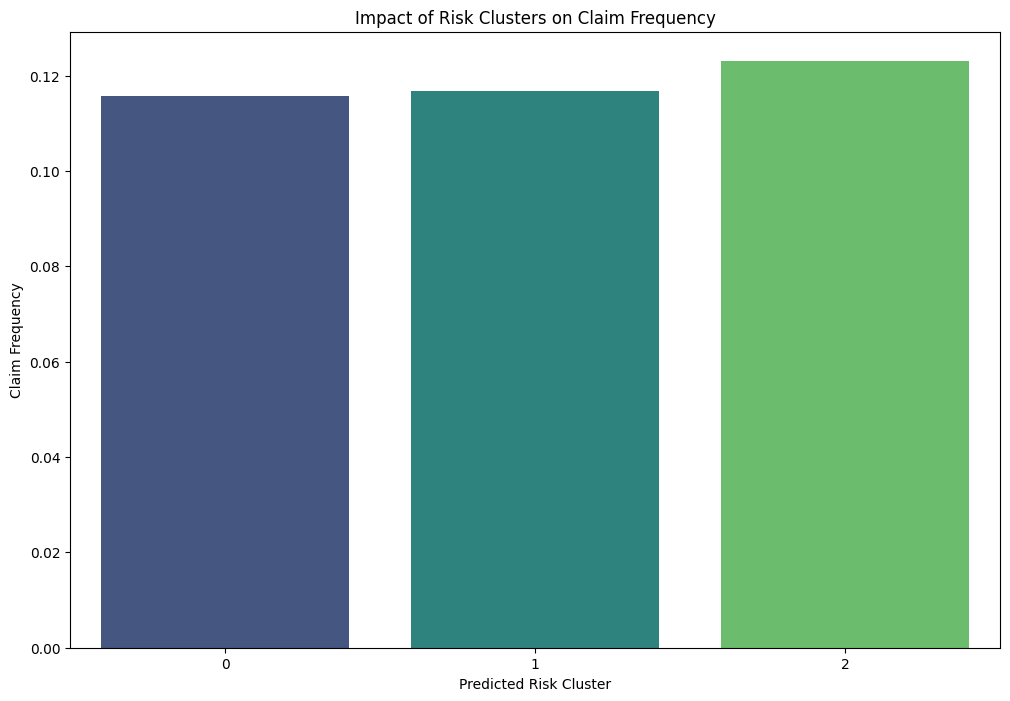

In [390]:
actual_claims['Frequency'] = actual_claims['ClaimNb'] / actual_claims['Exposure']

# Calculate the mean claim frequency for each predicted risk cluster
cluster_frequency_mean = actual_claims.groupby('Risk Cluster K-Mode')['Frequency'].mean().reset_index()

# Create a bar plot to visualize the impact of each cluster on claim frequency to see the riskiest cluster and the 'safest' cluster
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=cluster_frequency_mean, x='Risk Cluster K-Mode', y='Frequency', palette= 'viridis')

plt.title('Impact of Risk Clusters on Claim Frequency')
plt.xlabel('Predicted Risk Cluster')
plt.ylabel('Claim Frequency')
plt.show()

/var/folders/_j/nh059vw94tn4ypg5kqrr4hm40000gn/T/ipykernel_64395/2415496941.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=cluster_severity_mean, x='Risk Cluster K-Mode', y='ClaimAmount', palette= 'viridis')


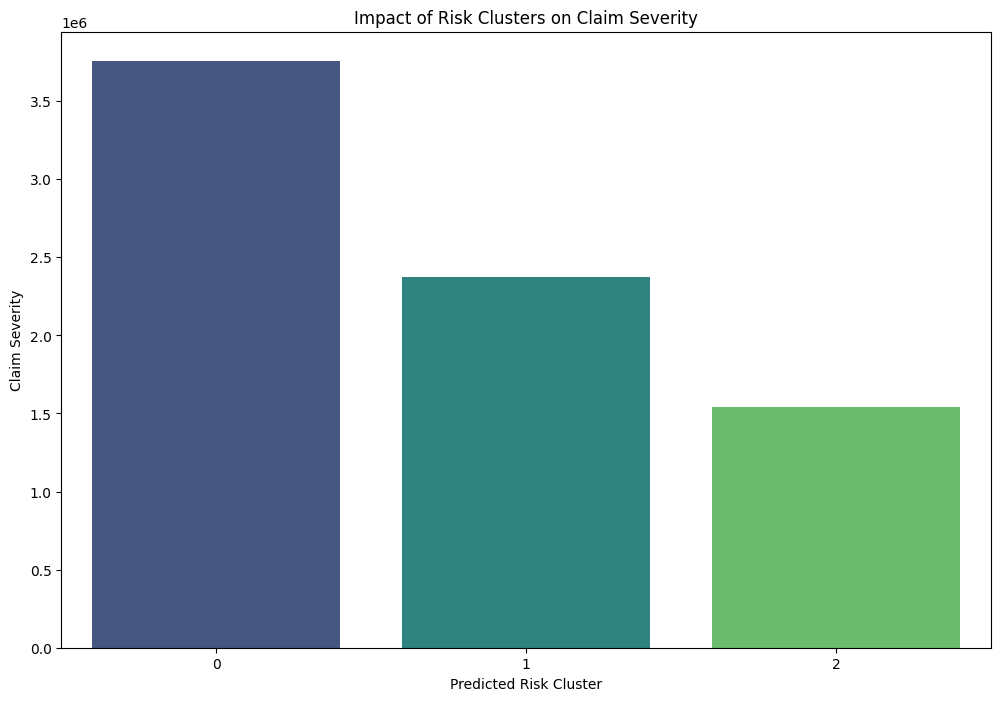

In [387]:
# Calculate the mean claim frequency for each predicted risk cluster
cluster_severity_mean = actual_claims.groupby('Risk Cluster K-Mode')['ClaimAmount'].sum().reset_index()

# Create a bar plot to visualize the impact of each cluster on claim frequency to see the riskiest cluster and the 'safest' cluster
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=cluster_severity_mean, x='Risk Cluster K-Mode', y='ClaimAmount', palette= 'viridis')

plt.title('Impact of Risk Clusters on Claim Severity')
plt.xlabel('Predicted Risk Cluster')
plt.ylabel('Claim Severity')
plt.show()

*Cluster 0*

In [445]:
# Cluster 0 
real_cluster_0['Premium_per_policy'] = real_cluster_0['Frequency'] * real_cluster_0['Severity']
real_cluster_0['Premium_per_policy'] = real_cluster_0['Premium_per_policy'].fillna(0)
real_cluster_0['Premium_per_policy'].mean()

258.8154540070887

*Cluster 1*

In [443]:
# Cluster 1 
real_cluster_1['Premium_per_policy'] = real_cluster_1['Frequency'] * real_cluster_1['Severity']
real_cluster_1['Premium_per_policy'] = real_cluster_1['Premium_per_policy'].fillna(0)
real_cluster_1['Premium_per_policy'].mean()

266.5112226853452

*Cluster 2*

In [444]:
# Cluster 2 
real_cluster_2['Premium_per_policy'] = real_cluster_2['Frequency'] * real_cluster_2['Severity']
real_cluster_2['Premium_per_policy'] = real_cluster_2['Premium_per_policy'].fillna(0)
real_cluster_2['Premium_per_policy'].mean()


266.930362249015

Adverse selection problem!


*Loss ratio*

In [451]:
real_cluster_0['Loss ratio'] = real_cluster_0['Severity'] / real_cluster_0['Premium_per_policy']
real_cluster_1['Loss ratio'] = real_cluster_1['Severity'] / real_cluster_1['Premium_per_policy']
real_cluster_2['Loss ratio'] = real_cluster_2['Severity'] / real_cluster_2['Premium_per_policy']

real_cluster_0['Loss ratio'].mean()

0.6573367056489402

In [449]:
real_cluster_1['Loss ratio'].mean()

0.6859896755162241

In [450]:
real_cluster_2['Loss ratio'].mean()

0.7062445030782762

Loss ratios are relatively stable = good !!!

*Problems we had:*

Problems fitting the distribution, we tested a lot of distributions (even distributions that were not included in the course such as the barr distribution).
Problem understanding how to do the monte carlo simulation (do we divide per cluster? only do for the whole distribution?)
Problem with calculating the premium, we had huge values at first - did a lot of reading. 
Problem with deciding which cluster method to chose - trade-off between complexity and accuracy of our results. 